<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
Автор материала: Data Scientist в Segmento Екатерина Демидова. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание 2. <br> Визуальный анализ данных о публикациях на Хабрахабре</center>

In [2]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

## Загрузка и знакомство с данными

Для работы вам понадобятся данные из нашего учебного конкурса на kaggle [«Прогноз популярности статьи на Хабре»](https://inclass.kaggle.com/c/howpop-habrahabr-favs-lognorm). Файл **`howpop_train.csv`** уже лежит в нашем репозитории в каталоге **`data`**, но его можно скачать и с Kaggle.

In [3]:
df = pd.read_csv('../../data/howpop_train.csv')

In [4]:
df.shape

(134137, 17)

In [5]:
df.head(3).T

,0,1,2
url,https://habrahabr.ru/post/18284/,https://habrahabr.ru/post/18285/,https://habrahabr.ru/post/18286/
domain,habrahabr.ru,habrahabr.ru,habrahabr.ru
post_id,18284,18285,18286
published,2008-01-01 18:19:00,2008-01-01 18:30:00,2008-01-01 18:34:00
author,@Tapac,@DezmASter,@DezmASter
flow,develop,design,design
polling,False,False,False
content_len,4305,7344,8431
title,Новогодний подарок блоггерам — WordPress 2.3.2,"Сумасшедшие яйца, или сервис для отслеживания ...","Сумасшедшие яйца, или сервис для отслеживания ..."
comments,0,1,47


Избавимся сразу от переменных, названия которых заканчиваются на `_lognorm` (нужны для соревнования на Kaggle). Выберем их с помощью `filter()` и удалим `drop`-ом:

In [6]:
df.drop(filter(lambda c: c.endswith('_lognorm'), df.columns), 
        axis = 1,       # axis = 1: столбцы 
        inplace = True) # избавляет от необходимости сохранять датасет

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
post_id,134137.0,181307.054265,81766.350702,18284.0,115565.0,182666.0,257401.0,314088.0
content_len,134137.0,7516.929699,8724.771640,1.0,2179.0,4949.0,9858.0,352471.0
comments,134137.0,39.625994,62.398958,0.0,7.0,19.0,48.0,2266.0
favs,134137.0,71.999866,145.854135,0.0,8.0,27.0,78.0,8718.0
views,134137.0,16631.013084,31479.819691,3.0,2100.0,7600.0,18700.0,1730000.0
votes_plus,133566.0,35.536888,42.461073,0.0,11.0,22.0,45.0,1466.0
votes_minus,133566.0,8.050035,11.398282,0.0,2.0,5.0,10.0,445.0


In [8]:
df.describe(include = ['object', 'bool'] # бинарные и категориальные переменные
           ).T

,count,unique,top,freq
url,134137,134137,https://habrahabr.ru/post/114381/,1
domain,134137,2,habrahabr.ru,97048
published,134137,130291,2011-06-14 15:52:00,39
author,97657,22077,@alizar,5292
flow,97048,6,develop,53318
polling,134137,2,False,129412
title,134137,133628,"Интересные события, произошедшие в выходные",56


In [9]:
# настройка внешнего вида графиков в seaborn
sns.set_style("dark")
sns.set_palette("RdBu")
sns.set_context("notebook", font_scale = 1.5, 
                rc = { "figure.figsize" : (15, 5), "axes.titlesize" : 18 })

Столбец **`published`** (время публикации) содержит строки. Чтобы мы могли работать с этими данными как с датой/временем публикации, приведём их к типу `datetime`:

In [10]:
print(df.published.dtype)
df['published'] = pd.to_datetime(df.published, yearfirst = True)
print(df.published.dtype)

object
datetime64[ns]


Создадим несколько столбцов на основе данных о времени публикации:

In [11]:
df['year'] = [d.year for d in df.published]
df['month'] = [d.month for d in df.published]

df['dayofweek'] = [d.isoweekday() for d in df.published]
df['hour'] = [d.hour for d in df.published]

-----
Теперь Ваша очередь. В каждом пункте предлагается построить картинку и с ее помощью ответить на вопрос в [форме](https://docs.google.com/forms/d/e/1FAIpQLSf3b5OG8zX_nLQBQ-t20c6M5Auz-VUL-yxj8Fm9_o_XWDBTrg/viewform?c=0&w=1). Конечно, можно попытаться ответить на все вопросы только с Pandas, без картинок, но мы советуем Вам потренироваться строить (красивые) визуализации.   

## 1\. В каком месяце (и какого года) было больше всего публикаций?

* март 2016,
* март 2015,
* апрель 2015,
* апрель 2016.

'2015-03'

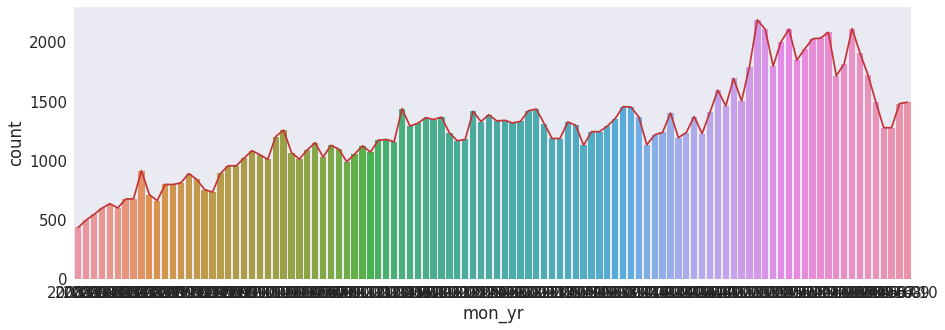

In [78]:
df.groupby(['year', 'month'])['post_id'].count().plot();
df['mon_yr'] = [d.isoformat()[:7] for d in df.published]
df['mon_yr'].value_counts()[:10]
max_posts_month = df['mon_yr'].value_counts().index[0]
sns.countplot(x='mon_yr', data=df)
max_posts_month

## 2\. Проанализируйте публикации в этом месяце (из вопроса 1)

Выберите один или несколько вариантов:

* На графике не заметны какие-либо выбросы или аномалии,
* Один или несколько дней сильно выделяются из общей картины,
* На хабре _всегда_ больше статей, чем на гиктаймсе,
* По субботам на гиктаймс и на хабрахабр публикуют примерно одинаковое число статей.

Подсказки: постройте график зависимости числа публикаций от дня; используйте параметр `hue`

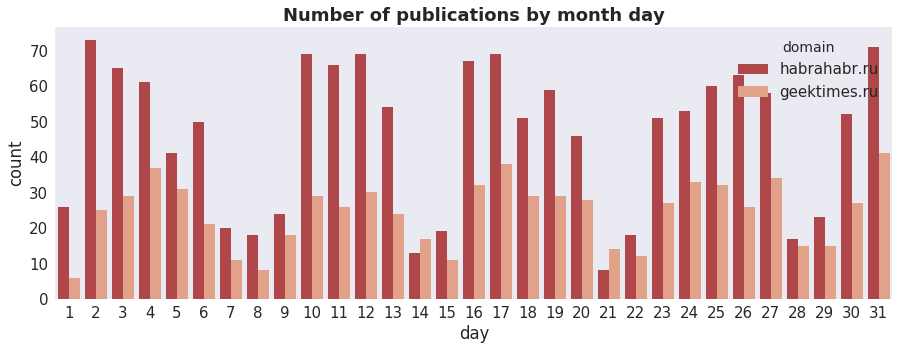

In [103]:
top_month_data = df[df['mon_yr'] == max_posts_month]

top_month_data['day'] = [d.day for d in top_month_data.published]

g = sns.countplot(x='day', data=top_month_data, hue='domain')
g.set_title("Number of publications by month day", fontweight = 'bold');

# хардкорный вариант с plot
# top_month_data = data.groupby(['dayofweek', 'domain'])['post_id'].agg('count');
# top_month_data.unstack(level=-1).plot(kind='bar') # Один или несколько дней сильно выделяются из общей картины,

In [ ]:
plt.set_label

## 3\. Выберите верное утверждение

* Больше всего просмотров (в среднем) набирают статьи, опубликованные в 12 часов дня;
* У опубликованных в 10 утра постов больше всего комментариев  (в среднем);
* Больше всего просмотров  (в среднем) набирают статьи, опубликованные в 6 часов утра;
* Максимальное число комментариев на гиктаймсе набрала статья, опубликованная в 9 часов вечера;
* На хабре дневные статьи комментируют чаще  (в среднем), чем вечерние.

38763   2011-07-01 02:35:00
Name: published, dtype: datetime64[ns]

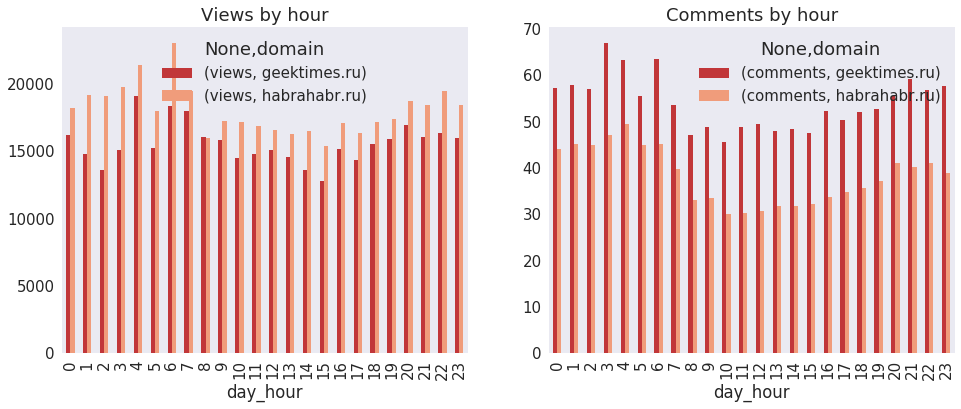

In [104]:
import matplotlib.pyplot as plt

df['day_hour'] = [d.hour for d in df.published]

_, axes = plt.subplots(1, 2, figsize=(16,6))
df.groupby(['day_hour', 'domain'])[['views']].mean().unstack(level=-1).plot(kind='bar', ax=axes[0], title = 'Views by hour')
df.groupby(['day_hour', 'domain'])[['comments']].mean().unstack(level=-1).plot(kind='bar', ax=axes[1], title = 'Comments by hour')
# Больше всего просмотров (в среднем) набирают статьи, опубликованные в 6 часов утра;
geektimes_df = df[df['domain'] == 'geektimes.ru']
geektimes_df[geektimes_df['comments'] == geektimes_df.comments.max()].published

## 4\. Кого из топ-20 авторов (по числу статей) чаще всего минусуют (в среднем)?

* @Mordatyj
* @Mithgol
* @alizar
* @ilya42

In [111]:
top20 = df.author.value_counts()[:20]
df[df['author'].isin(top20.index)].groupby('author')[['votes_minus']].mean().sort_values('votes_minus', ascending=False)

,votes_minus
author,
@Mithgol,20.481081
@Jeditobe,16.491713
@XaocCPS,15.286913
@andorro,13.654676
@aleksandrit,9.974643
@Sterhel,9.350785
@alizar,7.928191
@Mordatyj,7.471455
@ilya42,6.216797


## 5\. Сравните субботы и понедельники

Правда ли, что по субботам авторы пишут в основном днём, а по понедельникам — в основном вечером?

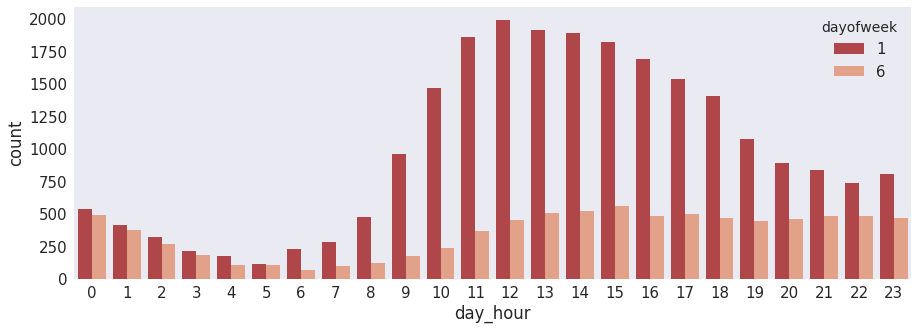

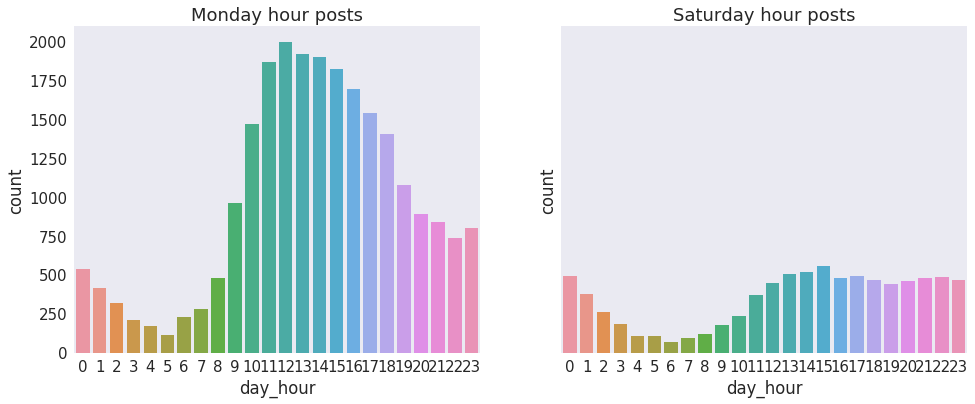

In [128]:
# variant 1

# оба графика на одной оси:
sns.countplot(x='day_hour', data=df[(df['dayofweek'] == 1) | (df['dayofweek'] == 6)], hue='dayofweek')

# и по отдельности
_, axes = plt.subplots(1, 2, sharey=True, figsize=(16,6))
g1 = sns.countplot(x='day_hour', data=df[df['dayofweek'] == 1], ax=axes[0])
g2 = sns.countplot(x='day_hour', data=df[df['dayofweek'] == 6], ax=axes[1])
g1.set_title('Monday hour posts')
g2.set_title('Saturday hour posts')


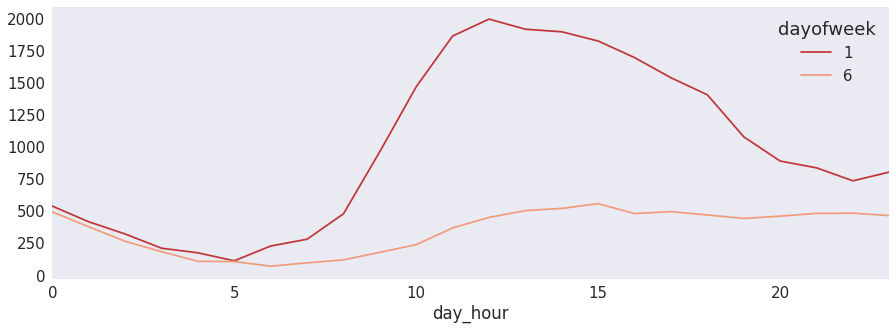

In [124]:
# variant 2

two_week_days_df = df[(df['dayofweek'] == 1) | (df['dayofweek'] == 6)]
# two_week_days_df['dayofweek'] = two_week_days_df['dayofweek'].map({'Monday': 1, 'Saturday': 6})  # not working
two_week_days_df.groupby(['dayofweek', 'day_hour'])['post_id'].count().unstack(level=0).plot()

# не правда